1. DIAGRAMAS DE VORONOI Y TRIANGULACIÓN DE DELAUNAY (copia del ejemplo de moodle)

Para calcular y dibujar el diagrama de Voronoi y la triangulación de Delaunay es necesario importar
de la libería scipy.spatial y de matplotlib las siguientes funciones.

In [1]:
from scipy.spatial import Delaunay,Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib as mpl

Además importaremos la librería numpy para poder generar arrays de puntos.

In [2]:
import numpy as np

El siguiente código genera aleatoriamente 10 puntos en el plano.

In [4]:
points = np.random.rand(10, 2) # 10 random points in 2-D

La siguiente expresión calcula el diagrama de Voronoi.

In [5]:
vor = Voronoi(points)

Para representarlo gráficamente:

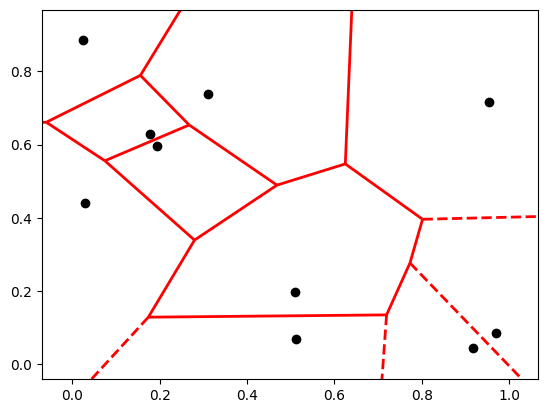

In [6]:
fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='red')
plt.plot(points[:,0], points[:,1], 'ko')

Para calcular la triangulación de Delaunay (une los puntos con regiones de Voronoi adyacentes).

In [7]:
Del= Delaunay(points)

El siguiente comando accede al array de símplices maximales (triángulos) de la triangulación de
Delaunay. ¡Ojo! Los vértices de los símplices no salen ordenados en orden lexicográfico

In [8]:
Del.simplices

array([[8, 2, 1],
       [2, 9, 1],
       [6, 2, 7],
       [2, 6, 9],
       [0, 8, 3],
       [0, 2, 8],
       [2, 4, 7],
       [0, 4, 2],
       [5, 0, 3],
       [5, 4, 0],
       [7, 5, 3],
       [4, 5, 7]], dtype=int32)

Para representar gráficamente la triangulación de Delaunay, imprimiendo los triangulos en color
verde y las aristas y vértices de color negro utilizamos la siguiente línea de comandos.

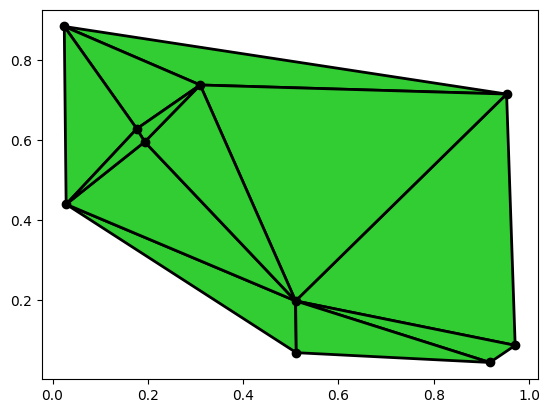

In [10]:
c=np.ones(len(points))
cmap = matplotlib.colors.ListedColormap("limegreen")
plt.tripcolor(points[:,0],points[:,1],Del.simplices, c, edgecolor="k", lw=2,cmap=cmap)
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()

Si queremos representar la triangulación de Delaunay sobre el diagrama de Voronoi hacemos lo
siguiente.

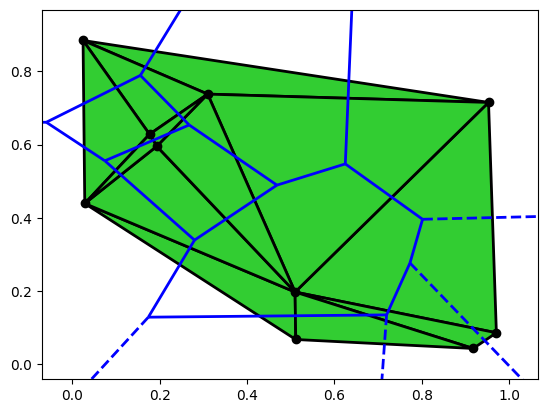

3

In [11]:
fig = voronoi_plot_2d(vor,show_vertices=False,line_width=2, line_colors='blue' )
c=np.ones(len(points))
cmap = matplotlib.colors.ListedColormap("limegreen")
plt.tripcolor(points[:,0],points[:,1],Del.simplices, c, edgecolor="k", lw=2,cmap=cmap)
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()
3


TAREAS: Definir una función que calcule la filtración de alfa complejos asociada a un conjunto de puntos del plano.


Definir una función que represente gráficamente dicho alfa complejo.


Definir una función que calcule la filtración de complejos de Vietoris-Rips asociada a un conjunto de puntos.